# Factorisation de matrice (SGD) avec PyCUDA

Pour mon projet d'éléments Logiciels de Traitement des Données Massives, je me suis intéressé à [cet article](https://arxiv.org/pdf/1610.05838.pdf) qui traite de l'algorithme de Stochastic Gradient Descent (SGD) pour factoriser des matrices, dans un contexte de calcul distribué.

On cherche à factoriser une matrice R (de taille m\*n) en deux matrices plus petites, P (m\*k) et Q (k\*n).

Pour résumer en deux mots le principe du SGD, il s'agit de calculer pour une seule cellule de la matrice l'erreur entre la prédiction et la réalité, puis d'updater les poids en fonction de cette erreur. La possibilité de parallélisation découle du fait que si deux cellules de R ne se trouvent ni dans la même ligne ni dans la même colonne, alors l'ajustement des poids découlant de l'une n'influencera pas sur celle de l'autre.

In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)
import matplotlib.pyplot as plt

np.random.seed(1234)

def create_from_template(template, function_name, v=False, **kwargs):
    """Le code PyCUDA devant être compilé,  il est souvent nécessaire pour chaque module d'avoir les dimensions des objets
    utilisés hardcodés. On prend le meilleur de C et python en créant un template qu'on peut formater avant de le compiler.
    On évite ainsi d'avoir à créer une fonction trop complexe (en calcul et en programmation) en C."""
    if v: print(template % kwargs)
    mod = SourceModule(template % kwargs)
    return mod.get_function(function_name)
    

Populating the interactive namespace from numpy and matplotlib


Pour s'assurer qu'il existe une solution à notre factorisation, on crée deux matrices P* et Q* qu'on multiplie pour obtenir notre matrice R*.

La carte graphique que j'ai à disposition n'est pas à proprement parler ajustée pour contenir des données "massives". 

Je compte donc plutôt démontrer l'intérêt d'utiliser la parallélisation offerte par le calcul sur GPU pour ce problème sur un jeu de données artificiel et relativement petit, sachant qu'il serait ensuite possible de l'implémenter sur un jeu de données réels (sous condition d'un meilleur hardware).

Il semblerait de plus que l'utilisation du notebook jupyter complique encore plus la tâche (du code lancé en script ne s'exécute pas dans une cellule notebook)... Enfin, si vous tentez d'utiliser printf dans les modules ([exemple](https://wiki.tiker.net/PyCuda/Examples/UsingPrintf)), il est parfois nécessaire d'utiliser la commande `cuda.Context.synchronize()` pour "débloquer" la sortie du buffer.

In [2]:
k = 100
m = 4000
n = 5000

(k*m+k*n)/(m*n) # Taille des matrices factorisées par rapport à la matrice originale

0.045

In [3]:
# Les floats utilisés en C on 32 bits, on les converti
p_o = np.random.randn(m, k).astype(np.float32)
q_o = np.random.randn(k, n).astype(np.float32)

On en profite pour se convaincre du bien fondé d'utiliser du calcul sous GPU, en effectuant la multiplication de la matrice avec PyCUDA. On compare le résultat à une multiplication de matrice classique sous numpy. 

In [4]:
multiply_by_line_template = """
                  __global__ void prodbyline (const float *p, const float *q, float *r)
                  {
                  const uint nq = %(nq)s; // number of columns in q
                  const uint np = %(np)s; // number of lines in p
                  const uint ncom= %(ncom)s; // number of lines in q and of column in p
                  const uint block_start = (blockIdx.x + gridDim.x * blockIdx.y) * blockDim.x; 
                  const uint startp = (threadIdx.x + block_start) * ncom;
                  const uint startr = (threadIdx.x + block_start) * nq;
                                
                  for (int linex = 0; linex < nq; linex++)
                      {
                      int idcell = linex + startr;
                      if (idcell >= np*nq)
                          break;
                      float sumcell = 0;
                      for (int idy = linex, idx = startp;
                           idx < startp + ncom;
                           idy += nq, idx++)
                             sumcell += p[idx] * q[idy];
                      r[idcell] = sumcell;
                      }
                  }
                  """

matmul = create_from_template(multiply_by_line_template, "prodbyline",
                              nq=n, ncom=k, np=m, v=True)

# Print le code tel qu'il sera compilé par pyCUDA


                  __global__ void prodbyline (const float *p, const float *q, float *r)
                  {
                  const uint nq = 5000; // number of columns in q
                  const uint np = 4000; // number of lines in p
                  const uint ncom= 100; // number of lines in q and of column in p
                  const uint block_start = (blockIdx.x + gridDim.x * blockIdx.y) * blockDim.x; 
                  const uint startp = (threadIdx.x + block_start) * ncom;
                  const uint startr = (threadIdx.x + block_start) * nq;
                                
                  for (int linex = 0; linex < nq; linex++)
                      {
                      int idcell = linex + startr;
                      if (idcell >= np*nq)
                          break;
                      float sumcell = 0;
                      for (int idy = linex, idx = startp;
                           idx < startp + ncom;
                           idy += nq, idx++)
 

In [5]:
# Charge les données sur la GPU
p_gpu = gpuarray.to_gpu(p_o)
q_gpu = gpuarray.to_gpu(q_o)

# On affecte les résultats à une matricel
res_matrix = gpuarray.zeros((m, n), dtype=np.float32)

In [6]:
matmul(p_gpu, q_gpu, res_matrix, block=(1024, 1, 1), grid=(2,2))
res = res_matrix.get()
np.abs(res - np.matmul(p_o, q_o)).max() # quelques différences liées à la précision du float32

0.0

In [7]:
%timeit np.matmul(p_o, q_o)

58.8 ms ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# Le magic %timeit a parfois du mal avec SourceModule

# On utilise time
import time

mat_speed = []
for i in range(1, 200):
    start = time.time()
    matmul(p_gpu, q_gpu, res_matrix, block=(512, 1, 1), grid=(1,1))
    end = time.time()
    mat_speed.append(end - start)

In [9]:
min(mat_speed), max(mat_speed)

(3.981590270996094e-05, 0.00012111663818359375)

... La multiplication de matrice telle qu'on l'a créée s'avère au mieux aussi efficace que la multiplication numpy. Cela est dû principalement aux nombreux aller-retour que l'on doit faire dans la mémoire. 

L'overhead d'envoyer les commandes au GPU est une autre explication possible de lenteur pour un si petit jeu de données.

Il pourrait être possible d'améliorer la performance en cachant par exemple la ligne utilisée pour la multiplication, ou en transposant la matrice Q avant d'effectuer la multiplication. [Voilà un exemple](https://wiki.tiker.net/PyCuda/Examples/MatrixmulTiled) de multiplication de matrice efficace sous PyCUDA.

Cela dit, on a toujours le même problème concernant le volume de données qu'on peut utiliser, bien inférieur à la limite de mémoire du GPU. J'utiliserai donc la multiplication numpy pour calculer l'erreur, sachant que cela n'est pas réellement nécessaire avant la fin de l'algorithme.

## Calcul de la fonction de perte

La fonction de perte se définit de la manière suivante:

\begin{equation*}
( \sum_{u,v} r_{uv} - p_uq_v )^2 + \lambda_p || p_u ||^2 + \lambda_q ||q_v||^2
\end{equation*}

les lambdas étant des constantes de normalisation visant à éviter l'overfitting.

In [2]:
from pycuda.elementwise import ElementwiseKernel

# Calcule l'erreur au carré de chaque cellule
error_kernel = ElementwiseKernel("const float *x, const float *y, float *z",
                                "z[i] = (x[i] - y[i])*(x[i] - y[i])",
                                "error_kernel")

# Calcule la somme sur une ligne ou une colonne
column_sum_template = """
                        __global__ void sumcol (const float *a, float *b)
                        {
                            const int nlines = %(nlines)s;
                            const int ncols = %(ncols)s;
                            const int block_start = blockDim.x * (blockIdx.x + gridDim.x * blockIdx.y);
                            const int idx_start = threadIdx.x + block_start ;
                            float sum = 0;
                            for (int idx = idx_start; idx < nlines * ncols; idx += ncols)
                                sum += a[idx];
                            b[idx_start] = sum;
                        }"""

Pour calculer les résultats par ligne, on peut par exemple transposer la matrice avant de calculer la somme par colonne, ou faire un nouveau module.

In [11]:
random_res = np.random.randn(m,n).astype(np.float32)
r_res_gpu = gpuarray.to_gpu(random_res)
diff_mat = gpuarray.empty_like(res_matrix)
a = res_matrix.get()
error_kernel(r_res_gpu, res_matrix, diff_mat) # Run the error kernel, output in diff_mat
np.abs(diff_mat.get() - (a - random_res)**2).max()

0.0

In [12]:
%timeit error_kernel(r_res_gpu, res_matrix, diff_mat)

5.36 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit (a - random_res)**2

39.3 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Voilà un clair avantage à l'utilisation du GPU ! 

On perd bien sûr une partie de cet avantage lorsqu'il s'agit de récupérer les données depuis la mémoire GPU, mais pour une taille de matrice conséquente on est clairement gagnant.

Pour montrer qu'il ne s'agit pas juste d'une question d'utiliser les built-ins ou non, regardons aussi les performances pour sommer les lignes et les colonnes :

In [14]:
sumcol = create_from_template(column_sum_template, 'sumcol', nlines=k, ncols=n)
out_sumcols = gpuarray.empty((1, n), dtype=np.float32) # Output array
sumcol(q_gpu, out_sumcols, block=(1024, 1, 1), grid=(4,2))
diff_sumcol = out_sumcols.get() - q_o.sum(axis=0)
np.abs(diff_sumcol).max()

0.0

In [17]:
%timeit sumcol(p_gpu, out_sumcols, block=(1024, 1, 1), grid=(2,2))

39.1 µs ± 341 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit p_o.sum(axis=1)

184 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


On n'a bien sûr pas besoin de passer par la somme des lignes et des colonnes pour calculer la norme euclidienne au carré, qui est probablement celle à laquelle les auteurs font référence.

In [3]:
square_kernel = ElementwiseKernel("const float *a, float *b",
                                 "b[i] = a[i]*a[i]",
                                 "square_kernel")

def total_cost(p, q, real_r, predicted_r, lambda_p = 0.03, lambda_q = 0.03):
    """Calcule la fonction de coût totale.
       Les matrices doivent être celles présentes sur le GPU.
       La norme utilisée est la norme euclidienne."""
    if real_r.shape != predicted_r.shape:
        raise ValueError("Predicted and real R must be the same size")
    # Create the placeholder matrixes
    p_squared = gpuarray.empty_like(p) 
    q_squared = gpuarray.empty_like(q)
    error_matrix = gpuarray.empty_like(real_r)
    # Square and calculate the error
    square_kernel(p, p_squared)
    square_kernel(q, q_squared)
    error_kernel(real_r, predicted_r, error_matrix)
    error = gpuarray.sum(error_matrix)
    return error + gpuarray.sum(p_squared) * lambda_p + gpuarray.sum(q_squared) * lambda_q, error

## Batch update

Les mécanismes Hogwild! et wavefront-update décrit dans le papier, bien qu'efficaces, sont complexes à mettre en place.

J'ai choisi d'imiter le principe du wavefront et de travailler par batch : pour chaque itération, un travailleur se verra affecter une ligne et une colonne pré-déterminée, compare la valeur calculée avec la véritable valeur de la cellule et met à jour les poids de la ligne de P et la colonne de Q correspondante.

On note que dans ce cas, il est inutile d'avoir plus de workers que de colonnes (ou de lignes, selon laquelle est la plus grande : dans un jeu de données réel, il y aura probablement plus d'utilisateur, les lignes, que de colonnes, qui seront par exemple les films à noter.

Le mécanisme d'update fonctionne de la manière suivante pour chaque travailleur :
 - Calcul de la prédiction pour la cellule de matrice affectée
 - Détermination de l'erreur par rapport à la matrice réelle
 - Ajustement des valeurs des colonnes et lignes correspondantes
    
J'ai suivi les recommandations de l'article sur l'ajustement des poids, on ajuste donc les poids selon la formule

\begin{align}
p_u \leftarrow \alpha (err_{u,v}q_v^T - \lambda_p p_u )\\
q_v \leftarrow \alpha (err_{u,v}p_u^T - \lambda_q q_v )\\
\end{align}

In [4]:
batch_calculation_template = """
                        __global__ void batch_update (const long *lines, const long *cols, float *p, float *q, const float *r)
                        {
                        const uint nq = %(ncols)s;
                        const uint ncom = %(ncom)s;
                        const float lambda_p = %(lambda_p)s;
                        const float lambda_q = %(lambda_q)s;
                        const float alpha = %(alpha)s;
                        const uint block_start = blockDim.x * (blockIdx.x + gridDim.x * blockIdx.y);
                        const uint worker_id = block_start + threadIdx.x;
                        const long worker_line = lines[worker_id];
                        const long worker_col = cols[worker_id];
                        const uint start_p = worker_line * ncom ;
                        const uint start_q = worker_col;
                        const float adj_p = 1 - alpha * lambda_p;
                        const float adj_q = 1 - alpha * lambda_q;
                        
                        // Calculate the value of the cell
                        float pred = 0;
                        for (uint idx = start_p, idy = start_q;
                             idx < start_p + ncom;
                             idy += nq, idx++){
                             pred += p[idx] * q[idy];
                             }
                        // Calculate the error
                        const uint r_id = worker_line * nq + worker_col;
                        const float err = r[r_id] - pred;
                        
                        //Adjust the weights
                        for (uint idx = start_p, idy = start_q;
                             idx < start_p + ncom;
                             idy += nq, idx++){
                             float placeholder = p[idx]; // Need a placeholder since we use p to adjust q
                             p[idx] *= adj_p;
                             p[idx] += alpha * err * q[idy];
                             q[idy] *= adj_q;
                             q[idy] += alpha * err * placeholder;
                             }
                        }"""

In [ ]:
batch_update = create_from_template(batch_calculation_template, "batch_update",
                                    ncols=n, ncom=k, lambda_p=0.03, lambda_q=0.03, alpha=0.08)

## Mise en pratique

On prend ici des matrices positives pour pouvoir les comparer avec l'algorithme NMF de scikit-learn

In [5]:
k = 30
m = 16000
n = 5000

(k*m+k*n)/(m*n) # Taille des matrices factorisées par rapport à la matrice originale

0.007875

In [6]:
# Les floats utilisés en C on 32 bits, on les converti
p_o = np.random.rand(m, k).astype(np.float32)
q_o = np.random.rand(k, n).astype(np.float32)

# Calcul de la matrice R
r = np.matmul(p_o, q_o)
r_gpu = gpuarray.to_gpu(r)

# Initialize the matrixes for the factorization
p = np.random.rand(m, k).astype(np.float32)
q = np.random.rand(k, n).astype(np.float32)

# Put to GPU
p_gpu = gpuarray.to_gpu(p)
q_gpu = gpuarray.to_gpu(q)

In [7]:
n_iter = 10000
n_workers = 4096

# Prepare the order matrices
p_order = np.arange(m)
q_order = np.arange(n)

# Training and normalization parameters
lambda_p = 0.01
lambda_q = 0.01
alpha = 0.08
batch_update = create_from_template(batch_calculation_template, "batch_update",
                                    ncols=n, ncom=k, lambda_p=lambda_p, 
                                    lambda_q=lambda_q, alpha=alpha)

In [8]:
cost_list = []
for i in range(n_iter):
    if i % 20 == 0 : # On ne récupère les données du GPU que toutes les 20 itérations
        pred = np.matmul(p_gpu.get(), q_gpu.get())
        pred_gpu = gpuarray.to_gpu(pred)
        cost = total_cost(p_gpu, q_gpu, r_gpu, pred_gpu, lambda_p, lambda_q)
        cost_list.append(cost[0].get().item(0))
    # Prepare the coordinates each worker will work on
    np.random.shuffle(p_order)
    np.random.shuffle(q_order)
    pgpu_order = gpuarray.to_gpu(p_order[:n_workers])
    qgpu_order = gpuarray.to_gpu(q_order[:n_workers])
    # Calculate and update the weights
    batch_update(pgpu_order, qgpu_order, p_gpu, q_gpu, r_gpu, block=(1024,1,1), grid=(2,2))

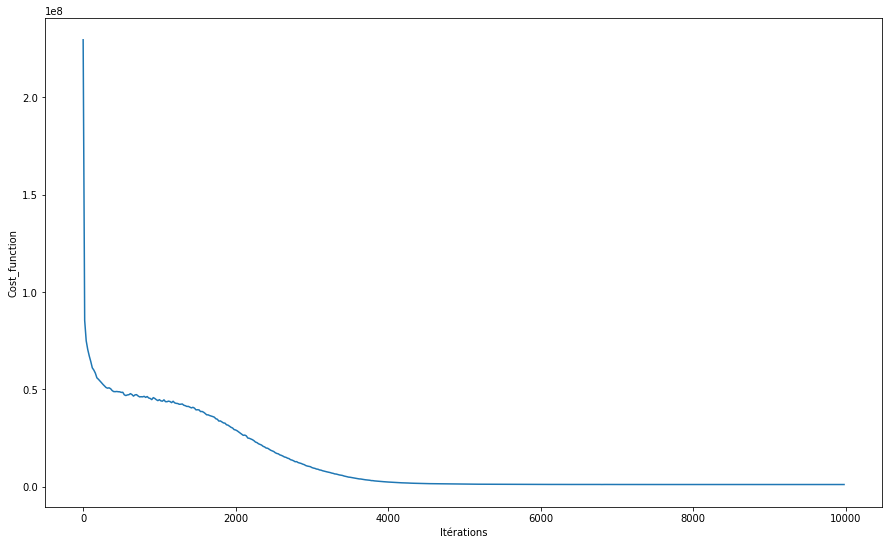

In [9]:
plt.plot(np.arange(0, n_iter, 20), cost_list)
plt.ylabel("Cost_function")
plt.xlabel("Itérations")
plt.show()

Il semblerait qu'au moins au niveau de la fonction de coût, notre algorithme converge (environ à la 5000ème itération).

Les poids peuvent encore varier au fur et à mesure des itérations mais les matrices factorisées sont de "qualité" comparables.

In [10]:
cost = total_cost(p_gpu, q_gpu, r_gpu, pred_gpu,lambda_p=lambda_p, lambda_q=lambda_q)
print("Fonction de coût: %f, erreur de reconstruction: %f" % (cost[0].get().item(0), cost[1].get().item(0)))

Fonction de coût: 1129524.500000, erreur de reconstruction: 1127486.250000


In [11]:
from sklearn.decomposition import NMF
# Peut encore s'améliorer avec plus d'itérations, mais c'est déjà très long
matrix_factorizer = NMF(n_components=k)
p_NMF = matrix_factorizer.fit_transform(r)
q_NMF = matrix_factorizer.components_

In [12]:
NMF_err = ((np.matmul(p_NMF, q_NMF) - r)**2).sum()
NMF_cost = lambda_p * (p_NMF**2).sum() + lambda_q * (q_NMF**2).sum() + NMF_err
print("Fonction de coût: %f, erreur de reconstruction: %f" % (NMF_cost, NMF_err))

Fonction de coût: 910570.025689, erreur de reconstruction: 908809.762225


In [29]:
%timeit matrix_factorizer.fit_transform(r)

2min 22s ± 9.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit

n_iter = 5000

# Initialize the matrixes for the factorization
p = np.random.rand(m, k).astype(np.float32)
q = np.random.rand(k, n).astype(np.float32)

# Put to GPU
p_gpu = gpuarray.to_gpu(p)
q_gpu = gpuarray.to_gpu(q)

for i in range(n_iter):
    # Prepare the coordinates each worker will work on
    np.random.shuffle(p_order)
    np.random.shuffle(q_order)
    pgpu_order = gpuarray.to_gpu(p_order[:n_workers])
    qgpu_order = gpuarray.to_gpu(q_order[:n_workers])
    # Calculate and update the weights
    batch_update(pgpu_order, qgpu_order, p_gpu, q_gpu, r_gpu, block=(1024,1,1), grid=(2,2))

8.54 s ± 7.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Bien sûr, on compare deux algorithmes différents, et j'ai un peu triché, puisque j'ai dû lancer une fois mon algorithme en calculant à chaque fois la fonction de coût pour savoir à partir de combien d'itérations celui-ci converge. Les allers-retours avec le GPU nous fait bien sûr perdre du temps (même si le calcul de la fonction de coût pourrait être améliorié pour ce cas particulier ou on refait la multiplication par le CPU)

L'économie de temps réalisée se fait au prix d'une certain perte de précision.


## Améliorations et prolongements

Le premier problème de notre SGD est la précision, comparée à l'algorithme de scikit-learn:
 - Comme pour la plupart des algorithmes de descente de gradient, l'initialisation des matrices de départ a une certaine importance. [La documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) scikit-learn nous donne plusieurs idées.
 - L'erreur est aussi à relativiser (ce n'est pas vraiment une piste d'amélioration). Le SGD nous donne une erreur moyenne d'environ 0.073 par cellule. S'il s'agit d'une note sur 10 (le maximum de r est ici de 15.9), par exemple pour des films, l'accéleration et la scalabilité offertes par la solution du SGD me paraît une raison tout à fait suffisante de la préferer à l'utilisation de scikit-learn.

Je sais que l'algorithme est bien sûr encore améliorable, soit en implémentant des suggestions de l'article, ou en améliorant différents points dans la manière dont je l'ai codé:

 - Limiter les aller-retours avec le GPU:
  - Calculer la matrice complète depuis le GPU, cela nous permettrait d'arrêter les itérations si elles n'apportent pas d'amélioration du coût au-delà d'un certain seuil plutôt que de fixer un nombre arbitraire d'itérations.
  - Trouver un moyen de déterminer les lignes et colonnes que chaque thread doit traiter depuis le GPU, ie réussir à mélanger les matrices "d'ordre" directement sur le GPU.
  
 - Implémenter un algorithme d'update plus complexe: le wavefront semblerait plus simple que le Hogwild!, mais toujours un peu long à coder pour que je puisse l'implémenter ici.
 
 - Pour traiter les données réelles : 
  - Les matrices qu'on factorise dans la vie réelle (je pense toujours par exemple aux notations de films) sont en général très sparse et contiennent des valeurs inconnues. Il faut donc donner des instructions pour qu'un thread qui rencontre un Nan sache quoi faire. Dans le cas de mon algorithme, je pourrais par exemple simplement donner l'instruction de ne rien faire (ce qui ralentirait la convergence)